# Foodie lovers

**Business case:** There will be a foodie fair in your city next summer (if coronavirus allows it to do), and the organsers have contacted us because they are interested in performing an analysis of the world wide cuisines. They manage to obtain a dataset from different cuisines all over the world, together with the list of the most common ingredients.

Some of our strongest geographic and cultural associations are tied to a region's local foods, so they are interested to know more information regarding them in order to organise the different stands. People from Marketing have ideas on how to plan the fair but they want to complement their ideas with some rough results.

**Business Question**
- We need to clearly communicate if a recipe is vegetarian or not, but due to the volume of recipes is hard to do it manually. Can we build a model to quickly tell if a receipt is vegetarian or not?
- We also need to separate the fair into sections where the stalls will be placed together according their similarities. Can we tell how many sections should we have and what would be the proposed sections?

In [54]:
# tip: use foodie_dataset.json to perform a complete analysis of the different cuisines. It is a json file so:

# json.load(open(path))

# You should:
# - Preprocess the dataset by using also NLP techniques
# - Frequency distribution, ie with wordcloud 
# - Visualisation techniques
# etc

In [55]:
#Clustering to find similar cuisines (KNN).
#Model to classify cuisine group by ingredients, classification (at least 2 models)

# Importing libraries and data

In [56]:
import numpy as np 
import pandas as pd 

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import imageio
from PIL import Image
import requests

# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV
from sklearn.decomposition import LatentDirichletAllocation

# matplotlib, seaborn and plotly for plotting
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [57]:
import json
filename = '../../datasets/Students_turn/Ex 6.1. foodie_dataset.json'
data = json.load(open(filename))

data = pd.DataFrame(data)
data

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."


# EDA

## Missing values

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [59]:
data.isnull().sum()

id             0
cuisine        0
ingredients    0
dtype: int64

## Exploring "cuisine" variable

In [60]:
per_vals = round(data["cuisine"].value_counts(normalize=True)*100, 2)

In [61]:
cuisines = data["cuisine"].value_counts().reset_index()
cuisines

,index,cuisine
0,italian,7838
1,mexican,6438
2,southern_us,4320
3,indian,3003
4,chinese,2673
5,french,2646
6,cajun_creole,1546
7,thai,1539
8,japanese,1423
9,greek,1175


In [62]:
fig = px.bar(cuisines, x="index", y="cuisine", color="index")
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

## Exploring "ingredients" variable

**Most used ingredients**

In [63]:
data.ingredients[1][1]

'ground pepper'

In [64]:
all_ingredients = []
for x in data['ingredients']:
    for y in x:
        all_ingredients.append(y)
len(all_ingredients)

428275

In [65]:
all_ingredients = pd.DataFrame(all_ingredients).rename(columns={0: "ingredients"})
all_ingredients = pd.DataFrame(all_ingredients.groupby("ingredients")["ingredients"].count()).rename(columns={"ingredients": "frequency"}).reset_index().sort_values(by="frequency", ascending=False)

In [66]:
all_ingredients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6714 entries, 5309 to 4424
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ingredients  6714 non-null   object
 1   frequency    6714 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 157.4+ KB


In [67]:
fig = px.bar(all_ingredients.head(10), y="frequency", x="ingredients", text="frequency", color="ingredients")
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

**Most used ingredients by cuisine**

In [68]:
all_cuisines = data.cuisine.unique()
all_cuisines

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

In [69]:
ing_by_cuisine = {}
for cuisine in all_cuisines:
    i_list = []
    for all_ingredients in data[data.cuisine == cuisine]["ingredients"]:
        for ing in all_ingredients:
            i_list.append(ing)
    ing_by_cuisine[cuisine] = i_list

In [70]:
ing_cs_table = []
for key, value in ing_by_cuisine.items():
    for n in value:
        ing_cs_table.append([key,n])
        

In [71]:
ing_cs_table = pd.DataFrame(ing_cs_table).rename(columns={0: "cuisine", 1:"ingredients"})
ing_cs_table = pd.DataFrame(ing_cs_table.groupby(["cuisine", "ingredients"]).size()).reset_index(col_fill='counts')

In [72]:
ing_cs_table.rename(columns={0: "count"}, inplace=True)

In [73]:
ing_cs_table.sort_values(by=["count"],ascending=False,inplace=True)

In [74]:
#ing_cs_table[ing_cs_table["cuisine"]==cs].head(10)

In [75]:
for cs in ing_cs_table["cuisine"].unique():
    fig = px.bar(ing_cs_table[ing_cs_table["cuisine"]==cs].head(10), y="count", x="ingredients", text="count", color="ingredients")
    fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
    fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', title=cs)
    fig.show()

## Text data processing

### Lemmatization

In [76]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,
    remove links,remove punctuation
    and remove words containing numbers.'''
    
    text = text.lower()
    text = re.sub('\[.*?\]', '', text) #remove text in square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text) #remove urls, https
    #text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text) #get rid of digits, ie numbers
    return text

In [77]:
data['ingredients'].head(4)


0    [romaine lettuce, black olives, grape tomatoes...
1    [plain flour, ground pepper, salt, tomatoes, g...
2    [eggs, pepper, salt, mayonaise, cooking oil, g...
3                  [water, vegetable oil, wheat, salt]
Name: ingredients, dtype: object

In [78]:
# Each row of data['ingredients'] is a list of strings; 
# we need to transform it in a string, in order to lemmatize 

def text_preprocess(text):
    """
    Cleaning and parsing the text.
    """
    from nltk.stem import WordNetLemmatizer
    from nltk.tokenize import word_tokenize   
# 1. replace ' ' with ', ' to be able to join compound ingredients after lemmatizing
    
    split_text = [text[i].replace(' ', ', ') for i in range(len(text))]
    
    # ex: df.ingredients[3] = [water, vegetable oil, wheat, salt]
    # split_text --> ['water', 'vegetable, oil', 'wheat', 'salt']
    
# 2. split each compound word by space only; see vegetable still has comma --> that is how we know 
    #it was a compounded with the following element in the list
    
    split_text2 = [word for line in split_text for word in line.split()]
    
    #split_text2 --> ['water', 'vegetable,', 'oil', 'wheat', 'salt']
    
# 3. apply lower case method for all words

    tokens = [w.lower() for w in split_text2]
# 4. instantiate WordNetLemmatizer() and the apply it on all words to drop plurals   
    lemmatizer = WordNetLemmatizer()
    lmtzr_words = [lemmatizer.lemmatize(word, 'n') for word in tokens]
    
# 5. join the list of strings in a single string
    lmtzr_words = ' '.join(lmtzr_words)
    #['water', 'vegetable,', 'oil', 'wheat', 'salt'] --> 'water vegetable, oil wheat salt'

# 6. each time it finds ', ' will transform it to '_', to join again the compound words
    lmtzr_words = lmtzr_words.replace(', ','_')
    # 'water vegetable, oil wheat salt' --> 'water vegetable_oil wheat salt'

# 7. use word_tokenize, to transform the string into a list of strings 
    token2 = word_tokenize(lmtzr_words)
    # 'water vegetable_oil wheat salt' --> ['water', 'vegetable_oil', 'wheat', 'salt']
    return token2

In [79]:
data["ingredients_txt"] = data['ingredients'].apply(lambda x: text_preprocess(x)).apply(','.join)
data['ingredients_txt'] = data['ingredients_txt'].apply(lambda x: clean_text(x))

In [80]:
data.head()

,id,cuisine,ingredients,ingredients_txt
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...","romaine_lettuce,black_olive,grape_tomato,garli..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...","plain_flour,ground_pepper,salt,tomato,ground_b..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...","egg,pepper,salt,mayonaise,cooking_oil,green_ch..."
3,22213,indian,"[water, vegetable oil, wheat, salt]","water,vegetable_oil,wheat,salt"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...","black_pepper,shallot,cornflour,cayenne_pepper,..."


In [81]:
#data['ingredients_txt'] = data["ingredients_txt"].str.replace(" ", "_")

In [82]:
data['ingredients_txt']

0        romaine_lettuce,black_olive,grape_tomato,garli...
1        plain_flour,ground_pepper,salt,tomato,ground_b...
2        egg,pepper,salt,mayonaise,cooking_oil,green_ch...
3                           water,vegetable_oil,wheat,salt
4        black_pepper,shallot,cornflour,cayenne_pepper,...
                               ...                        
39769    light_brown_sugar,granulated_sugar,butter,warm...
39770    kraft_zesty_italian_dressing,purple_onion,broc...
39771    egg,citrus_fruit,raisin,sourdough_starter,flou...
39772    boneless_chicken_skinless_thigh,minced_garlic,...
39773    green_chile,jalapeno_chilies,onion,ground_blac...
Name: ingredients_txt, Length: 39774, dtype: object

In [83]:
def plot_wordcloud(wordcloud):
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title("Most Common Ingredients", fontsize=18, fontweight='bold')
    plt.show()

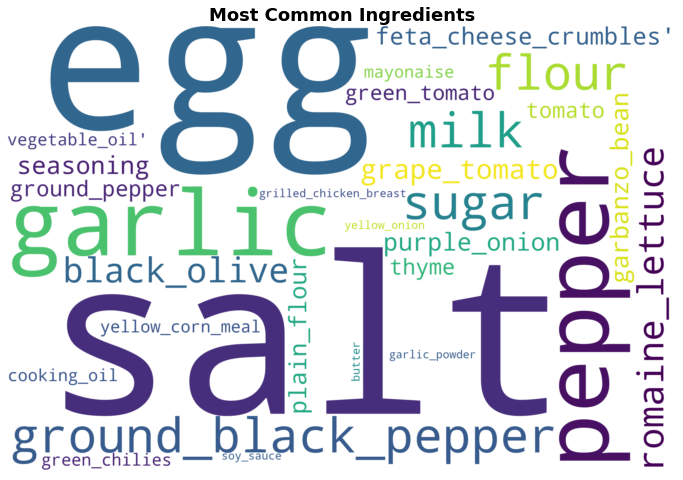

In [152]:
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=None, max_words=30,
                      background_color="white", 
                      width=3000, height=2000,collocations=False,
                      stopwords = stopwords.words('english')).generate(str(data.ingredients_txt.values))

plot_wordcloud(wordcloud)

### Data classification: is_veg?

In [85]:
non_veget_prod = ['meat','chicken', 'turkey','duck','goose','beef',
                  'pork','lamb','mutton', 'goat_meat', 'venison',
                  'rabbit', 'tenderloin', 'filet_mignon', 'steak',
                  'sirloin', 'tomahawk', 'bacon','ham', 'hot_dog',
                  'jamon', 'salami', 'sausage', 'burger', 'poultry',
                  'deer', 'boar', 'bison', 'buffalo', 'pheasant','partridge',
                  'liver', 'kidney', 'spleen','tripe', 'heart',
                  'tongue', 'intestine', 'brain', 'seafood', 'abalone',
                  'muttonshells', 'anchovy',  'barracuda', 'barramundi',
                  'bass', 'bluenose', 'bullhead', 'capelin', 'carp', 'caviar',
                  'seabass', 'chub', 'clam', 'cobia', 'cod', 'conch', 'corvina',
                  'crab', 'croaker', 'cusk', 'dab', 'drum', 'eel', 'escolar',
                  'flounder', 'frog', 'grenadier', 'grouper', 'haddock', 'hake',
                  'halibut', 'herring', 'crab', 'lingcod', 'lobster', 'mackerel',
                  'marlin', 'mullet', 'muskellunge', 'mussels', 'pout', 'octopus',
                  'opah', 'opaleye', 'orangeroughy', 'oyster', 'pangasius', 'fish',
                  'perch', 'pickerel', 'pike', 'pilchards', 'plaice', 'pomfret',
                  'pompano', 'pollock', 'porgy', 'salmon', 'sanddabs', 'sardine',
                  'scad', 'scallops', 'scrod', 'scup', 'shad', 'shark','skate',
                  'snail', 'escargot', 'sole', 'squid', 'shrimp','calamari',
                  'stripedbass', 'sturgeon', 'sucker', 'pumpkinseed', 'swai',
                  'tatoaba', 'tilapia', 'trevally', 'trout', 'tuna', 'turbot',
                  'turtle', 'wahoo', 'walleye', 'whiting', 'yellowtail', 'crabs',
                  'lobsters', 'craw', 'shrimps', 'prawns', 'cockle', 'cuttlefish',
                  'clam', 'loco', 'mussel', 'octopus', 'oyster', 'periwinkle',
                  'squid', 'conch','snails',  'nautilus', 'surimi']

In [86]:
non_veg = data.loc[data['ingredients_txt'].apply(lambda x: any(k in x for k in non_veget_prod)) == True]
non_veg['is_veg'] = 0
non_veg.head()

,id,cuisine,ingredients,ingredients_txt,is_veg
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...","egg,pepper,salt,mayonaise,cooking_oil,green_ch...",0
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...","black_pepper,shallot,cornflour,cayenne_pepper,...",0
6,42779,spanish,"[olive oil, salt, medium shrimp, pepper, garli...","olive_oil,salt,medium_shrimp,pepper,garlic,cho...",0
8,16903,mexican,"[olive oil, purple onion, fresh pineapple, por...","olive_oil,purple_onion,fresh_pineapple,pork,po...",0
10,5875,italian,"[pimentos, sweet pepper, dried oregano, olive ...","pimento,sweet_pepper,dried_oregano,olive_oil,g...",0


In [87]:
veg = data.loc[data['ingredients_txt'].apply(lambda x: any(k in x for k in non_veget_prod )) == False]
veg['is_veg'] = 1
veg.head()


,id,cuisine,ingredients,ingredients_txt,is_veg
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...","romaine_lettuce,black_olive,grape_tomato,garli...",1
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...","plain_flour,ground_pepper,salt,tomato,ground_b...",1
3,22213,indian,"[water, vegetable oil, wheat, salt]","water,vegetable_oil,wheat,salt",1
5,6602,jamaican,"[plain flour, sugar, butter, eggs, fresh ginge...","plain_flour,sugar,butter,egg,fresh_ginger_root...",1
7,3735,italian,"[sugar, pistachio nuts, white almond bark, flo...","sugar,pistachio_nut,white_almond_bark,flour,va...",1


In [88]:
data = pd.concat([non_veg, veg]).sort_index()

In [89]:
data.head()

,id,cuisine,ingredients,ingredients_txt,is_veg
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...","romaine_lettuce,black_olive,grape_tomato,garli...",1
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...","plain_flour,ground_pepper,salt,tomato,ground_b...",1
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...","egg,pepper,salt,mayonaise,cooking_oil,green_ch...",0
3,22213,indian,"[water, vegetable oil, wheat, salt]","water,vegetable_oil,wheat,salt",1
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...","black_pepper,shallot,cornflour,cayenne_pepper,...",0


In [90]:
data['is_veg'].value_counts()

0    21950
1    17824
Name: is_veg, dtype: int64

In [91]:
non_veg_recip = data[data['is_veg'] == 0]['ingredients_txt']
veg_recip = data[data['is_veg'] == 1]['ingredients_txt']

Text(0.5, 1.0, 'Non Vegetarian Recipes')

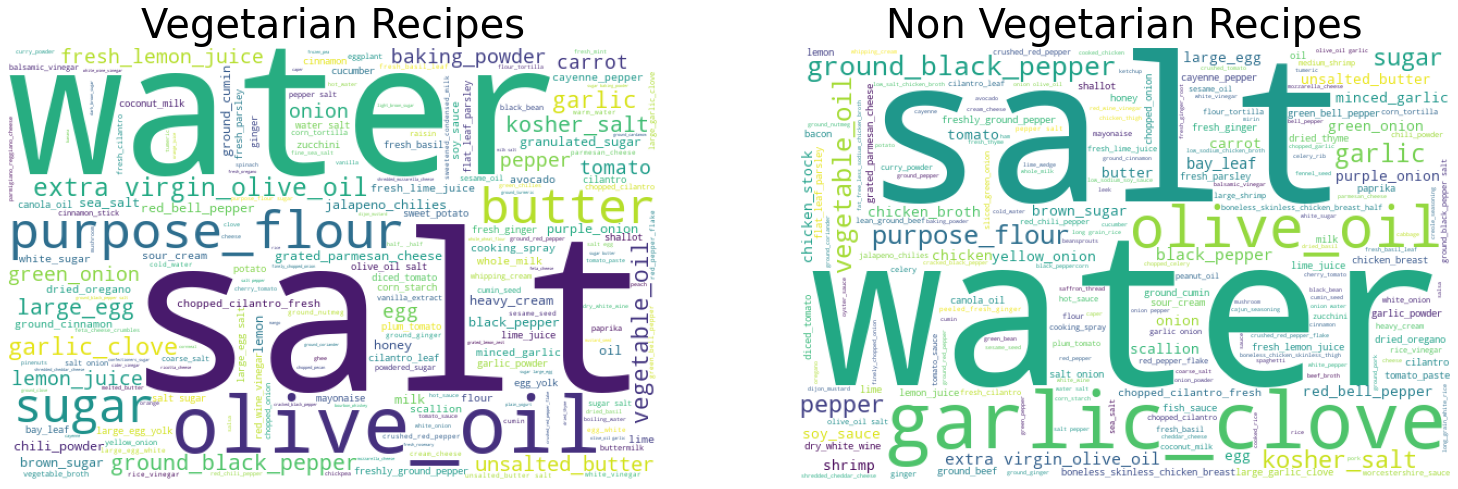

In [92]:
from wordcloud import WordCloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])

wordcloud1 = WordCloud(background_color='white',
                        width=600,
                        height=400).generate(" ".join(veg_recip))

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Vegetarian Recipes',fontsize=40)

wordcloud2 = WordCloud(background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_veg_recip))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Vegetarian Recipes',fontsize=40)

## Vectorizing

### Bag of Words - Countvectorizer Features

In [93]:
count_vectorizer = CountVectorizer(max_features = 1500)
train_vectors = count_vectorizer.fit_transform(data["ingredients_txt"])
train_vectors

<39774x1500 sparse matrix of type '<class 'numpy.int64'>'
	with 413401 stored elements in Compressed Sparse Row format>

In [94]:
train_vectors.toarray()


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### TFIDF Features

In [95]:
tfidf = TfidfVectorizer(max_features=1500, min_df=2,
                        max_df=0.5, ngram_range=(1, 2))

train_tfidf = tfidf.fit_transform(data["ingredients_txt"])

train_tfidf

<39774x1500 sparse matrix of type '<class 'numpy.float64'>'
	with 454842 stored elements in Compressed Sparse Row format>

In [96]:
train_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Building a classification model

In [97]:
import sys
sys.path.insert(0, '../')

from fx_MLClassification import *

### Fitting a simple Logistic Regression on BOW

In [98]:
y = data['is_veg']
X = train_vectors

In [99]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [100]:
clf_bow = LogisticRegression()
model_bow = clf_bow.fit(X_train, y_train)

In [101]:
Allmetrics(model_bow, X_train, y_train, X_test, y_test)

-----------------------------------------
TRAIN results
-----------------------------------------
Confusion Matrix 
 [[14273  1143]
 [  167 12258]]
-----------------------------------------
TEST results
-----------------------------------------
Confusion Matrix 
 [[5936  598]
 [ 129 5270]]
 Classification report 
    precision    recall  f1-score  support
0   0.978730  0.908479  0.942297   6534.0
1   0.898091  0.976107  0.935475   5399.0

++++++++ Summary of the Metrics +++++++++++++++++++++++++++++++++++
       Accuracy  Precision    Recall        f1
Train  0.941813   0.940496  0.945060  0.941516
test   0.939077   0.938411  0.942293  0.938886


,Accuracy,Precision,Recall,f1
Train,0.941813,0.940496,0.945060,0.941516
test,0.939077,0.938411,0.942293,0.938886


In [103]:
y = data['is_veg']
X = train_vectors
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,
                                                 random_state=42)
clf_bow = LogisticRegression()
model_bow = clf_bow.fit(X_train, y_train)

In [104]:
from sklearn.model_selection import GridSearchCV

penalty = ['l1', 'l2'] #type of regularisation technique.
#L2 is called Ridge Regression
#L1 is Lasso

C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
#degree of penalization, regularization

class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6},
                {1:0.6, 0:0.4}, {1:0.7, 0:0.3}, {1:0.3, 0:0.7}] 
#weigth that you want to give to each of the classes

solver = ['liblinear', 'saga'] 
#Algorithm to use in the optimization problem.For small datasets: ‘liblinear’;
# and ‘sag’ and ‘saga’ works faster for large datasets.

In [106]:
param_grid = dict(penalty=penalty, C=C, 
                  class_weight=class_weight, 
                  solver=solver)

grid = GridSearchCV(estimator = model_bow, param_grid=param_grid, 
                    scoring='roc_auc',
                    verbose=1, n_jobs=-1, cv=5)

In [107]:
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


In [108]:
grid_result

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': [{0: 0.5, 1: 0.5}, {0: 0.6, 1: 0.4},
                                          {0: 0.4, 1: 0.6}, {0: 0.3, 1: 0.7},
                                          {0: 0.7, 1: 0.3}],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='roc_auc', verbose=1)

In [109]:
clf_bow = LogisticRegression(**grid_result.best_params_,random_state=42)

model_bow = clf_bow.fit(X_train,y_train)

In [110]:
Allmetrics(clf_bow, X_train, y_train, X_test, y_test)

-----------------------------------------
TRAIN results
-----------------------------------------
Confusion Matrix 
 [[14099  1317]
 [    7 12418]]
-----------------------------------------
TEST results
-----------------------------------------
Confusion Matrix 
 [[5903  631]
 [  35 5364]]
 Classification report 
    precision    recall  f1-score  support
0   0.994106  0.903428  0.946600   6534.0
1   0.894746  0.993517  0.941548   5399.0

++++++++ Summary of the Metrics +++++++++++++++++++++++++++++++++++
       Accuracy  Precision    Recall        f1
Train  0.944830   0.944498  0.949643  0.944649
test   0.944188   0.944426  0.948473  0.944074


,Accuracy,Precision,Recall,f1
Train,0.944830,0.944498,0.949643,0.944649
test,0.944188,0.944426,0.948473,0.944074


### Fitting a simple Logistic Regression on TFIDF

In [111]:
y = data['is_veg']
X = train_tfidf

In [112]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [113]:
clf_tfidf = LogisticRegression()
model_tfidf = clf_tfidf.fit(X_train, y_train)

In [114]:
Allmetrics(model_tfidf, X_train, y_train, X_test, y_test)

-----------------------------------------
TRAIN results
-----------------------------------------
Confusion Matrix 
 [[13881  1535]
 [  831 11594]]
-----------------------------------------
TEST results
-----------------------------------------
Confusion Matrix 
 [[5734  800]
 [ 475 4924]]
 Classification report 
    precision    recall  f1-score  support
0   0.923498  0.877564  0.899945   6534.0
1   0.860238  0.912021  0.885373   5399.0

++++++++ Summary of the Metrics +++++++++++++++++++++++++++++++++++
       Accuracy  Precision    Recall        f1
Train  0.897669   0.895887  0.898992  0.896937
test   0.893153   0.891868  0.894792  0.892659


,Accuracy,Precision,Recall,f1
Train,0.897669,0.895887,0.898992,0.896937
test,0.893153,0.891868,0.894792,0.892659


**Hypertunning the model**

In [115]:
y = data['is_veg']
X = train_tfidf
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,
                                                 random_state=42)
clf_tfidf = LogisticRegression()
model_tfidf = clf_tfidf.fit(X_train, y_train)

In [116]:
from sklearn.model_selection import GridSearchCV

penalty = ['l1', 'l2'] #type of regularisation technique.
#L2 is called Ridge Regression
#L1 is Lasso

C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
#degree of penalization, regularization

class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6},
                {1:0.6, 0:0.4}, {1:0.7, 0:0.3}, {1:0.3, 0:0.7}] 
#weigth that you want to give to each of the classes

solver = ['liblinear', 'saga'] 
#Algorithm to use in the optimization problem.For small datasets: ‘liblinear’;
# and ‘sag’ and ‘saga’ works faster for large datasets.

In [117]:
param_grid = dict(penalty=penalty, C=C, 
                  class_weight=class_weight, 
                  solver=solver)

grid = GridSearchCV(estimator = model_tfidf, param_grid=param_grid, 
                    scoring='roc_auc',
                    verbose=1, n_jobs=-1, cv=5)

In [118]:
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


In [119]:
grid_result

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': [{0: 0.5, 1: 0.5}, {0: 0.6, 1: 0.4},
                                          {0: 0.4, 1: 0.6}, {0: 0.3, 1: 0.7},
                                          {0: 0.7, 1: 0.3}],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='roc_auc', verbose=1)

In [120]:
clf_tfidf = LogisticRegression(**grid_result.best_params_,random_state=42)

model_tfidf = clf_tfidf.fit(X_train,y_train)

In [121]:
Allmetrics(clf_tfidf, X_train, y_train, X_test, y_test)

-----------------------------------------
TRAIN results
-----------------------------------------
Confusion Matrix 
 [[13183  2233]
 [   57 12368]]
-----------------------------------------
TEST results
-----------------------------------------
Confusion Matrix 
 [[5483 1051]
 [  63 5336]]
 Classification report 
    precision    recall  f1-score  support
0   0.988640  0.839149  0.907781   6534.0
1   0.835447  0.988331  0.905481   5399.0

++++++++ Summary of the Metrics +++++++++++++++++++++++++++++++++++
       Accuracy  Precision    Recall        f1
Train  0.905607   0.909760  0.913296  0.905540
test   0.906645   0.912044  0.913740  0.906631


,Accuracy,Precision,Recall,f1
Train,0.905607,0.909760,0.913296,0.905540
test,0.906645,0.912044,0.913740,0.906631


### Fitting a Random Forest on TFIDF 

In [122]:
y = data['is_veg']
X = train_tfidf

In [123]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [124]:
from sklearn.ensemble import RandomForestClassifier

rand_forest = RandomForestClassifier(n_estimators=200)
rand_forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [125]:
y_pred_RF = rand_forest.predict(X_test)

print(classification_report(y_test, y_pred_RF))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      6534
           1       0.85      0.84      0.84      5399

    accuracy                           0.86     11933
   macro avg       0.86      0.86      0.86     11933
weighted avg       0.86      0.86      0.86     11933



In [126]:
Allmetrics(rand_forest, X_train, y_train, X_test, y_test)

-----------------------------------------
TRAIN results
-----------------------------------------
Confusion Matrix 
 [[15399    17]
 [    2 12423]]
-----------------------------------------
TEST results
-----------------------------------------
Confusion Matrix 
 [[5753  781]
 [ 884 4515]]
 Classification report 
    precision    recall  f1-score  support
0   0.866807  0.880471  0.873586   6534.0
1   0.852530  0.836266  0.844320   5399.0

++++++++ Summary of the Metrics +++++++++++++++++++++++++++++++++++
       Accuracy  Precision    Recall        f1
Train  0.861715   0.860852  0.858936  0.859752
test   0.860471   0.859669  0.858369  0.858953


,Accuracy,Precision,Recall,f1
Train,0.861715,0.860852,0.858936,0.859752
test,0.860471,0.859669,0.858369,0.858953


## Topic Modelling

In [127]:
lda = LatentDirichletAllocation(n_components=4, max_iter=5,
                                learning_method = 'online', #mini-batch of training data to 
                                #update the ``components_``variable incrementally. 
                                learning_offset = 50.,#parameter that downweights early 
                                #iterations in online learning.
                                random_state = 42)

In [128]:
lda

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=4, random_state=42)

In [129]:
lda_model = lda.fit(train_tfidf)

In [130]:
lda_model

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=4, random_state=42)

In [131]:
lda_model.components_[1]

array([ 0.25487162,  0.25099436, 66.92771286, ...,  0.44645093,
       39.84774144,  0.31305925])

In [132]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [133]:
n_top_words = 20
print("\nTopics in LDA model: ")
tf_feature_names = tfidf.get_feature_names()

#tf_feature_names
print_top_words(lda_model, tf_feature_names, n_top_words)


Topics in LDA model: 

Topic #0:onion salt ground_cumin pepper garlic chili_powder jalapeno_chilies sour_cream chopped_cilantro_fresh garlic_powder tomato olive_oil avocado paprika diced_tomato cayenne_pepper salsa corn_tortilla flour_tortilla vegetable_oil

Topic #1:soy_sauce water sugar garlic sesame_oil scallion vegetable_oil green_onion corn_starch rice_vinegar fresh_ginger fish_sauce ginger carrot salt garlic_clove brown_sugar onion sesame_seed oil

Topic #2:olive_oil extra virgin_olive_oil extra virgin_olive_oil garlic_clove ground_black_pepper salt grated_parmesan_cheese fresh_lemon_juice fresh_parsley garlic onion fresh_basil dry_white_wine flat_leaf_parsley kosher_salt black_pepper pepper butter tomato

Topic #3:purpose_flour all purpose_flour all sugar salt butter milk unsalted_butter large_egg egg baking_powder water vanilla_extract ground_cinnamon baking_soda buttermilk white_sugar cumin_seed flour ground_turmeric


In [134]:
latin_cuisine = lda_model.components_[0]
asian_cuisine = lda_model.components_[1]
mediterranean_cuisine = lda_model.components_[2]
confectionary = lda_model.components_[3]

In [135]:
type(latin_cuisine)

numpy.ndarray

In [136]:
#latin_cuisine.argsort()

In [137]:
#latin_cuisine = np.flipud(latin_cuisine)

In [138]:
#latin_cuisine

In [139]:
#latin_cuisine.argsort()

In [140]:
latin_cuisine_words = [tf_feature_names[i] for i in latin_cuisine.argsort()[:-30 - 1 :-1]]
asian_cuisine_words = [tf_feature_names[i] for i in asian_cuisine.argsort()[:-30 - 1 :-1]]
confectionary_words = [tf_feature_names[i] for i in confectionary.argsort()[:-30 - 1 :-1]]
mediterranean_cuisine_words = [tf_feature_names[i] for i in mediterranean_cuisine.argsort()[:-30 - 1 :-1]]
#argsort() sorts in descending way->x[startAt:endBefore:skip]
#second_topic_words = [tf_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]
#third_topic_words = [tf_feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]
#fourth_topic_words = [tf_feature_names[i] for i in fourth_topic.argsort()[:-50 - 1 :-1]]

In [141]:
latin_cuisine_words

['onion',
 'salt',
 'ground_cumin',
 'pepper',
 'garlic',
 'chili_powder',
 'jalapeno_chilies',
 'sour_cream',
 'chopped_cilantro_fresh',
 'garlic_powder',
 'tomato',
 'olive_oil',
 'avocado',
 'paprika',
 'diced_tomato',
 'cayenne_pepper',
 'salsa',
 'corn_tortilla',
 'flour_tortilla',
 'vegetable_oil',
 'water',
 'shredded_cheddar_cheese',
 'green_onion',
 'green_bell_pepper',
 'black_bean',
 'ground_beef',
 'cumin',
 'garlic_clove',
 'ground_black_pepper',
 'purple_onion']

In [142]:
latin = np.array(Image.open(requests.get('https://img.favpng.com/23/0/17/world-map-globe-south-america-latin-america-png-favpng-Bwt8nNdaaWmwpvnGesVCePXKU.jpg', stream=True).raw))

In [143]:
asia = np.array(Image.open(requests.get('https://cdn.imgbin.com/0/14/8/imgbin-east-asia-world-map-world-map-blank-map-map-RidpKqqdDAdqLk7gE8Y8tgnsS.jpg', stream=True).raw))

In [144]:
confectionary_img = np.array(Image.open(requests.get('https://img1.pnghut.com/2/1/23/RHKGS8KE5c/black-and-white-dessert-cake-confectionery-frosting-icing.jpg', stream=True).raw))

In [145]:
mediterranean = np.array(Image.open(requests.get('https://upload.wikimedia.org/wikipedia/commons/thumb/e/e0/Blank_Map_of_Mediterranean_Sea_region.svg/1600px-Blank_Map_of_Mediterranean_Sea_region.svg.png', stream=True).raw))

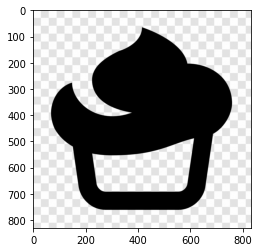

In [146]:
plt.imshow(confectionary_img)

In [147]:
stop_words = ["salt"] + list(STOPWORDS)
to_colormap = 'tab10'

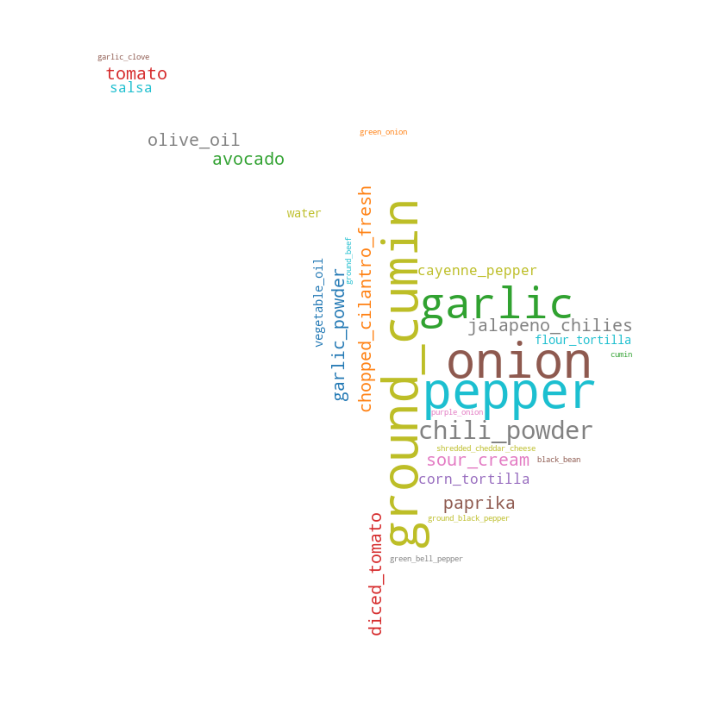

In [148]:
plt.figure(figsize=(16,13))
firstcloud = WordCloud(stopwords=stop_words,
                        background_color='white',
                        width=2500,
                        height=1800, mask=latin
                         ).generate(" ".join(latin_cuisine_words))
plt.imshow(firstcloud.recolor( colormap= to_colormap , random_state=17), alpha=0.98)
plt.axis('off')
plt.show()

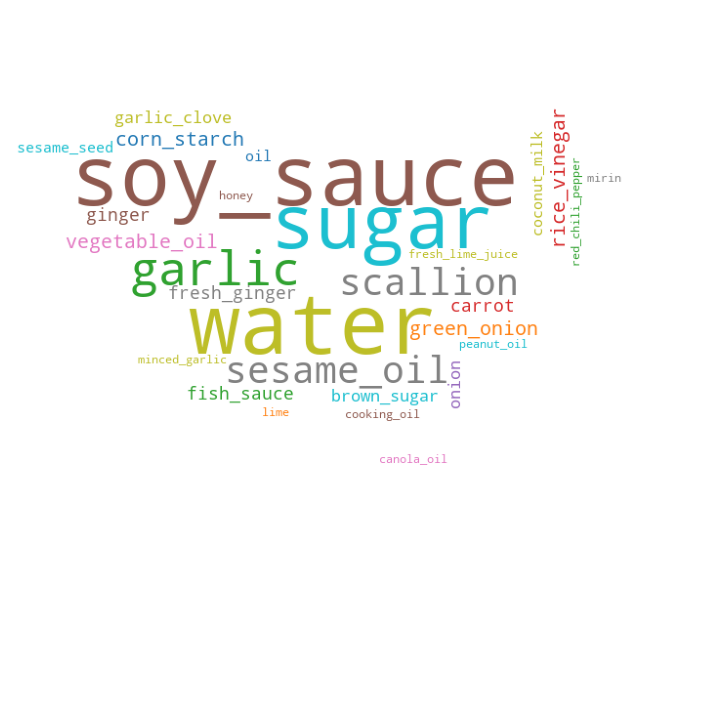

In [149]:
plt.figure(figsize=(16,13))
firstcloud = WordCloud(stopwords=stop_words,
                        background_color='white',
                        width=2500,
                        height=1800, mask=asia
                         ).generate(" ".join(asian_cuisine_words))
plt.imshow(firstcloud.recolor( colormap= to_colormap , random_state=17), alpha=0.98)
plt.axis('off')
plt.show()

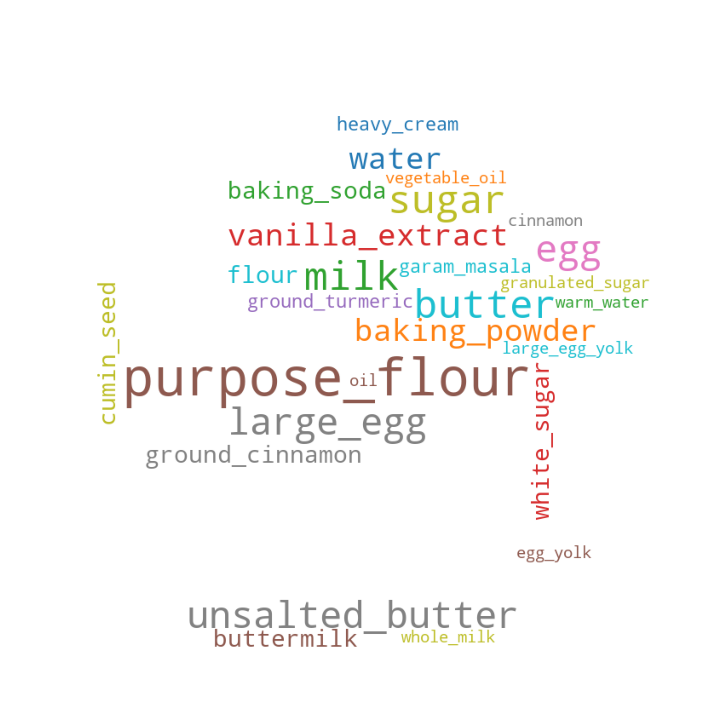

In [150]:
plt.figure(figsize=(16,13))
firstcloud = WordCloud(stopwords=stop_words,
                        background_color='white',
                        width=2500,
                        height=1800, mask=confectionary_img
                         ).generate(" ".join(confectionary_words))
plt.imshow(firstcloud.recolor( colormap= to_colormap , random_state=17), alpha=0.98)
plt.axis('off')
plt.show()

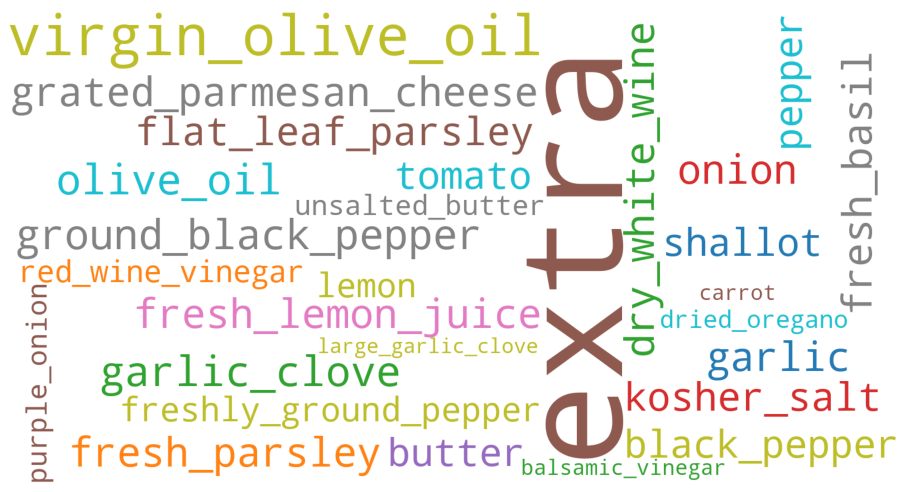

In [151]:
plt.figure(figsize=(16,13))
firstcloud = WordCloud(stopwords=stop_words,
                        background_color='white',
                        width=2500,
                        height=1800, mask=mediterranean,
                         ).generate(" ".join(mediterranean_cuisine_words))
plt.imshow(firstcloud.recolor( colormap= to_colormap , random_state=17), alpha=0.98)
plt.axis('off')
plt.show()